In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from typing import Literal

In [3]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["munich"]:
        return "It's 15 degrees Celsius and cloudy."
    else:
        return "It's 32 degrees Celsius and sunny."

In [4]:
get_weather.invoke(input={"location": "munich"})

"It's 15 degrees Celsius and cloudy."

In [5]:
tools = [get_weather]
model = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

In [6]:
model.invoke("hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 45, 'total_tokens': 55, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BpcOVaamkGYUoljrNpq5uR10mvWSE', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a9bea010-a13c-4eae-9932-71c408574fd6-0', usage_metadata={'input_tokens': 45, 'output_tokens': 10, 'total_tokens': 55, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [7]:
model.invoke("How is the weather in munich?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Qqu4nbebVBN8R6IACMGQWhHV', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 52, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BpcOVpHkObHT54ZrUdBX6yd5M3q4B', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--fff6dab2-d32b-44e6-978a-1a45e609c5ea-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_Qqu4nbebVBN8R6IACMGQWhHV', 'type': 'tool_call'}], usage_metadata={'input_tokens': 52, 'output_tokens': 15, 'total_tokens': 67, 'input_token_details'

In [8]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [9]:
workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

In [10]:
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

In [11]:
graph = workflow.compile()

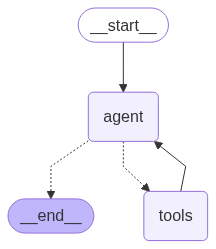

In [12]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [13]:
from langchain_core.messages import HumanMessage

messages1 = [HumanMessage(content="Hello, how are you?")]
messages2 = [HumanMessage(content="How is the weather in munich?")]

In [14]:
graph.invoke({"messages": messages1})

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='921c8439-02ba-477a-8a5f-62486cb862ec'),
  AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 50, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BpcOWbURZkwub3sUVnvEsqTf73eOh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e2e53926-032d-4090-a35e-45cff5a0bed7-0', usage_metadata={'input_tokens': 50, 'output_tokens': 30, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_re

In [15]:
graph.invoke({"messages": messages2})

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='02fdb2e5-296b-4a47-8a34-ac1526ef76ea'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MiwAdWv9E61ZkeiWurNYwnhO', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 52, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BpcOXRrfmgixrNNcgmLdlcOapudfT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6d4be8b8-6f55-499b-9195-cb3893508f49-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'i

In [16]:
graph.invoke(
    {
        "messages": [
            HumanMessage(content="What would you recommend to do in that city than?")
        ]
    }
)

{'messages': [HumanMessage(content='What would you recommend to do in that city than?', additional_kwargs={}, response_metadata={}, id='a436b6d0-fab8-4b27-9ee2-700e3e457eaa'),
  AIMessage(content="Could you please specify which city you're referring to?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 55, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BpcOZmwfeUVmEYa0nilqZl1xqRYpR', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8d1cf10c-5111-4317-a8ff-4cabc776c042-0', usage_metadata={'input_tokens': 55, 'output_tokens': 11, 'total_tokens': 66, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details

### Add Memory to chatbot

In [17]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [18]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile(checkpointer=checkpointer)

In [19]:
graph.invoke(
    {"messages": [HumanMessage(content="How is the weather in munich?")]},
    config={"configurable": {"thread_id": 1}},
)

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='4f416216-5157-4a77-a03b-0fcb2f8661e6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XVSpKKAzhJgdvsdSMWr3oROc', 'function': {'arguments': '{"location":"munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 52, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BpcOZlpyVu4fZsduVZ0plu90vpXoF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--59ca0135-5644-4432-9104-535a24ab3d2c-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'munich'}, 'i

In [20]:
graph.invoke(
    {
        "messages": [
            HumanMessage(content="What would you recommend to do in that city than?")
        ]
    },
    config={"configurable": {"thread_id": 1}},
)

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='4f416216-5157-4a77-a03b-0fcb2f8661e6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XVSpKKAzhJgdvsdSMWr3oROc', 'function': {'arguments': '{"location":"munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 52, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BpcOZlpyVu4fZsduVZ0plu90vpXoF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--59ca0135-5644-4432-9104-535a24ab3d2c-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'munich'}, 'i